# Proyek Klasifikasi Gambar: Intel Image Classification
- **Nama:** Michael Elbert Justian
- **Email:** michaelej2005@gmail.com
- **ID Dicoding:** michael_ej

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Import module yang disediakan oleh google collab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"michaelelbertjustian","key":"6c1181447d0a51da72c644564a8ac4c5"}'}

In [4]:
# Download kaggle dataset and unzip the file
# 1. Create the .kaggle directory
!mkdir -p ~/.kaggle/

# 2. Copy the kaggle.json file into the directory
!cp kaggle.json ~/.kaggle/

# 3. Secure the credentials file
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download the dataset
# It saves as 'labeled-chest-xray-images.zip' in the current working directory
!kaggle datasets download -d puneet6060/intel-image-classification

# 5. Unzip the downloaded file
!unzip -q intel-image-classification.zip # -q for quiet output

# 6. Check the files to confirm the data path (optional, but helpful)
!ls -F

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 78% 269M/346M [00:00<00:00, 627MB/s] 
100% 346M/346M [00:00<00:00, 609MB/s]
intel-image-classification.zip	sample_data/  seg_test/
kaggle.json			seg_pred/     seg_train/


In [5]:
# Direktori awal untuk train dan test
train_dir = "intel_image_classification/train"
test_dir = "intel_image_classification/test"
pred_dir = "intel_image_classification/Prediction"

# Direktori baru untuk dataset gabungan
combined_dir = "intel_image_classification/Dataset"

In [6]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(pred_dir, exist_ok=True)
os.makedirs(combined_dir, exist_ok=True)

In [7]:
# Pindahin semua data ke intel_image_classification
source_test_dir = 'seg_test/seg_test'
source_train_dir = 'seg_train/seg_train'

# Salin file dan folder dari train
for category in os.listdir(source_train_dir):
  category_dir = os.path.join(source_train_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(source_test_dir):
  category_dir = os.path.join(source_test_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

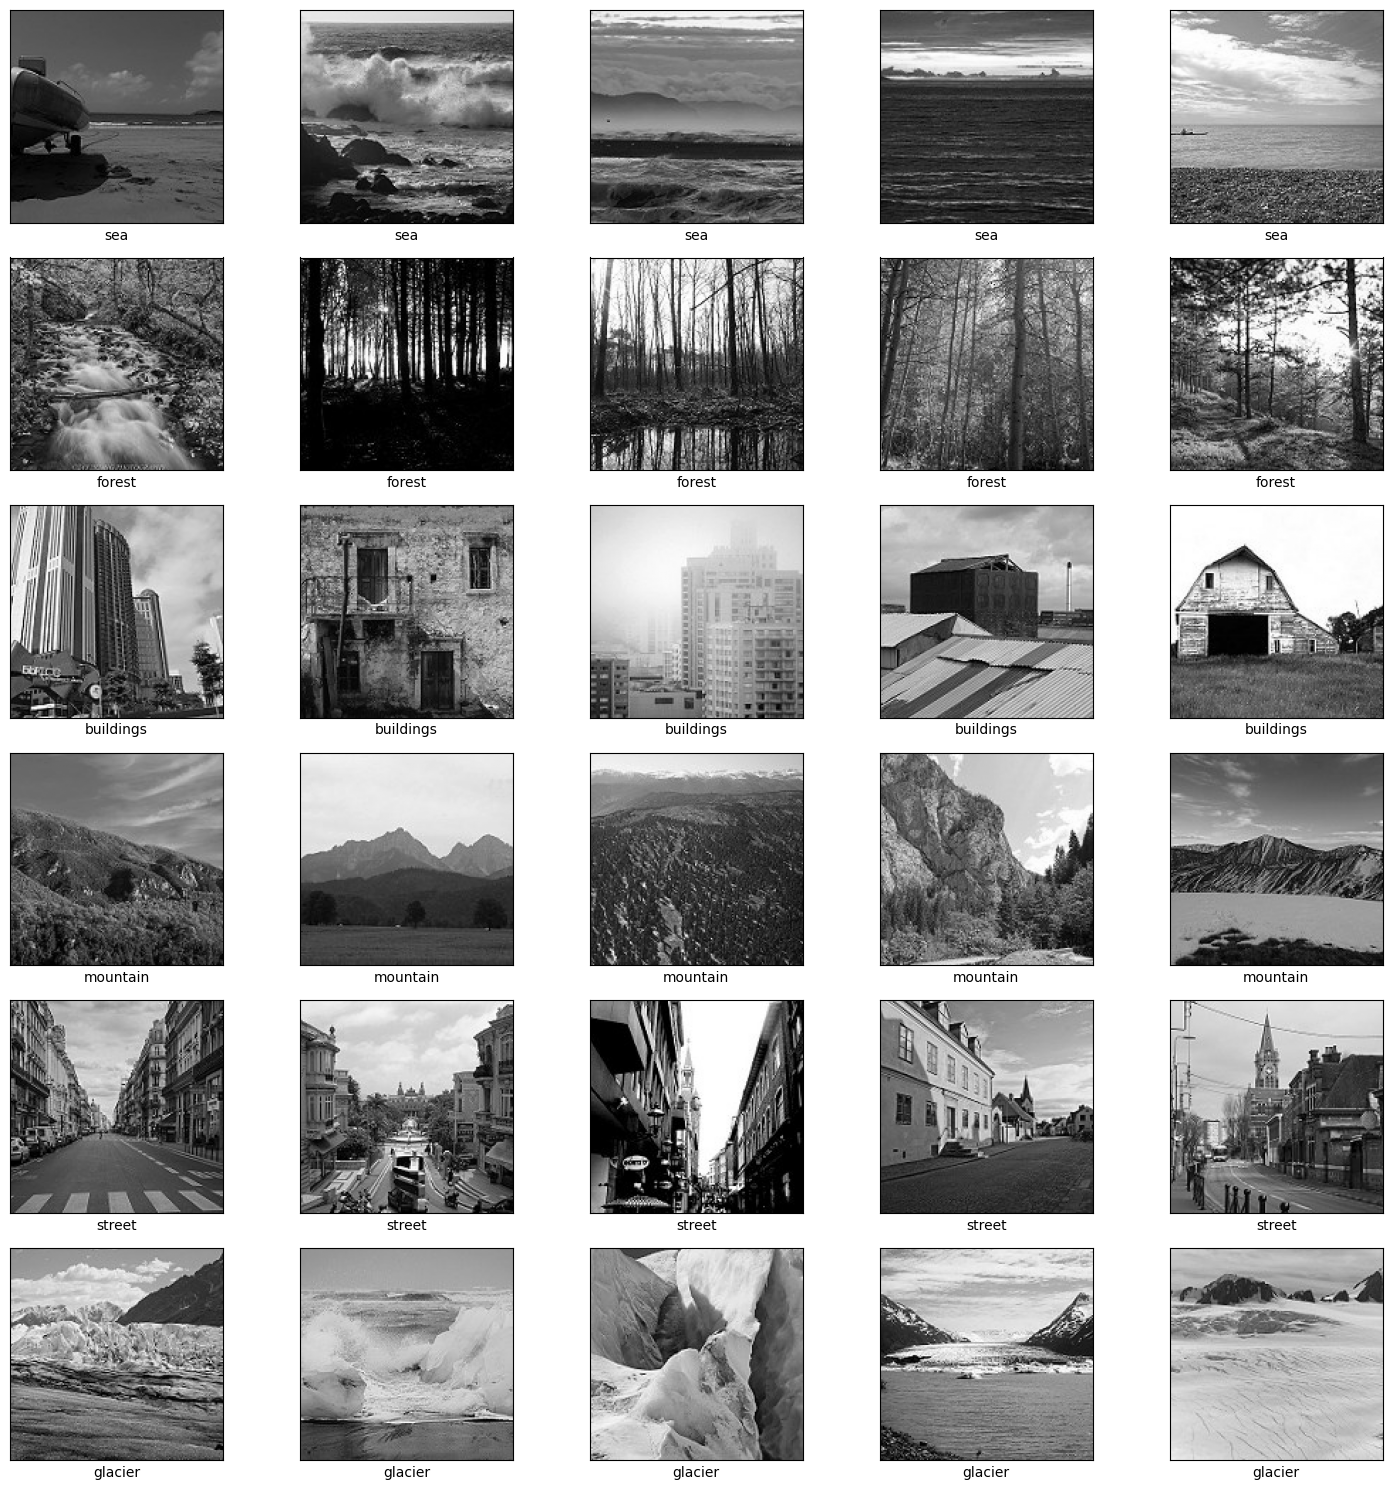

In [8]:
import matplotlib.pyplot as plt

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
scenery_image = {}

# Tentukan path sumber train
path = "intel_image_classification/"
path_sub = os.path.join(path, "Dataset")
for i in os.listdir(path_sub):
    scenery_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "intel_image_classification/Dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(scenery_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(scenery_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()


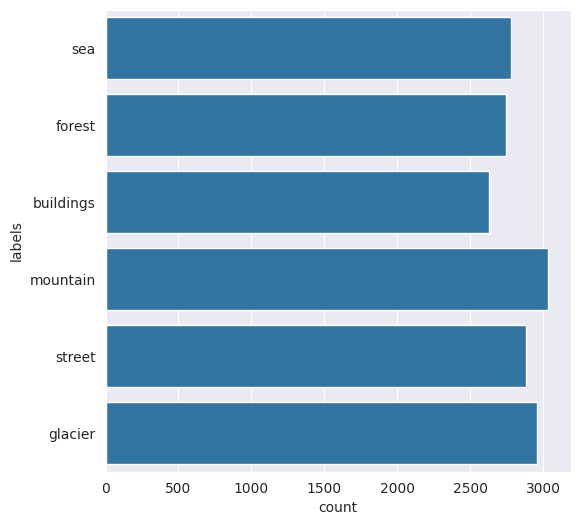

In [9]:
import seaborn as sns

# Definisikan path sumber
scenery_path = "intel_image_classification/Dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai DataFrame
for path, subdirs, files in os.walk(scenery_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels": labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [10]:
mypath= 'intel_image_classification/Dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
buildings,2628
forest,2745
glacier,2957
mountain,3037
sea,2784
street,2883


### Data Preprocessing

#### Split Dataset

In [11]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X = df['path']
y = df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

In [12]:
# Menyatukan kembali ke masing-masing dataframe
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [13]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "intel_image_classification/Dataset/"


set    labels   
test   buildings     531
       forest        535
       glacier       608
       mountain      616
       sea           554
       street        563
train  buildings    2097
       forest       2210
       glacier      2349
       mountain     2421
       sea          2230
       street       2320
dtype: int64 


                                                    path     labels    set
5146   intel_image_classification/Dataset/buildings/1...  buildings  train
1170   intel_image_classification/Dataset/forest/1773...     forest  train
11013    intel_image_classification/Dataset/sea/3158.jpg        sea  train
11325  intel_image_classification/Dataset/street/1080...     street  train
2400     intel_image_classification/Dataset/sea/7664.jpg        sea  train


In [14]:
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "intel_image_classification/"

# Memindahkan file dari dataframe ke folder train dan test
for index, row in tq(df_all.iterrows()):
  # Deteksi Filepath
  file_path = row['path']
  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['labels'], row['image'].split('.')[0])

  # Buat direktori tujuan folder
  if os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels']))

  # Tentukan tujuan file
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

  # Salin file dari sumber ke tujuan
  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

In [15]:
# Definisikan direktori training dan test
TRAIN_DIR = "intel_image_classification/train/"
TEST_DIR = "intel_image_classification/test/"

train_buildings = os.path.join(TRAIN_DIR, 'buildings')
train_forest = os.path.join(TRAIN_DIR, 'forest')
train_glacier = os.path.join(TRAIN_DIR, 'glacier')
train_mountain = os.path.join(TRAIN_DIR, 'mountain')
train_sea = os.path.join(TRAIN_DIR, 'sea')
train_street = os.path.join(TRAIN_DIR, 'forest')

test_buildings = os.path.join(TEST_DIR, 'buildings')
test_forest = os.path.join(TEST_DIR, 'forest')
test_glacier = os.path.join(TEST_DIR, 'glacier')
test_mountain = os.path.join(TEST_DIR, 'mountain')
test_sea = os.path.join(TEST_DIR, 'sea')
test_street = os.path.join(TEST_DIR, 'street')

print("Total number of buildings image in training set: ", len(os.listdir(train_buildings)))
print("Total number of forest image in training set: ", len(os.listdir(train_forest)))
print("Total number of glacier image in training set: ", len(os.listdir(train_glacier)))
print("Total number of mountain image in training set: ", len(os.listdir(train_mountain)))
print("Total number of sea image in training set: ", len(os.listdir(train_sea)))
print("Total number of forest image in training set: ", len(os.listdir(train_forest)))

print("\n")

print("Total number of buildings image in test set: ", len(os.listdir(test_buildings)))
print("Total number of forest image in test set: ", len(os.listdir(test_forest)))
print("Total number of glacier image in test set: ", len(os.listdir(test_glacier)))
print("Total number of mountain image in test set: ", len(os.listdir(test_mountain)))
print("Total number of sea image in test set: ", len(os.listdir(test_sea)))
print("Total number of street image in test set: ", len(os.listdir(test_street)))

Total number of buildings image in training set:  2097
Total number of forest image in training set:  2210
Total number of glacier image in training set:  2349
Total number of mountain image in training set:  2421
Total number of sea image in training set:  2230
Total number of forest image in training set:  2210


Total number of buildings image in test set:  531
Total number of forest image in test set:  535
Total number of glacier image in test set:  608
Total number of mountain image in test set:  616
Total number of sea image in test set:  554
Total number of street image in test set:  563


In [16]:
datagen = ImageDataGenerator(
    rescale = 1/255.,
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255
)


train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                  batch_size=32,
                                                  target_size=(150,150),
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  subset='validation',
                                                  shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                batch_size=1,
                                                target_size=(150,150),
                                                color_mode="rgb",
                                                class_mode='categorical',  # <--- UBAH INI
                                                shuffle=False)

Found 10903 images belonging to 6 classes.
Found 2724 images belonging to 6 classes.
Found 3407 images belonging to 6 classes.


## Modelling

In [17]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False, # Jangan sertakan layer klasifikasi asli
    input_shape=(150, 150, 3) # Sesuaikan dengan gambar Anda (RGB)
)

# Bekukan (freeze) base model agar bobotnya tidak berubah saat training
base_model.trainable = False


model_1 = Sequential()

# Tambahkan base model yang sudah dibekukan sebagai layer pertama
model_1.add(base_model)

# Tambahkan layer konvolusi untuk ekstraksi fitur tambahan
model_1.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D((2, 2)))

# Tambahkan layer-layer baru di atasnya
model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(128, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.5))

# Layer output untuk 6 kelas dengan aktivasi softmax
model_1.add(Dense(6, activation='softmax'))

model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ModelCheckpoint
checkpoint_cb = ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='accuracy',
    mode='max',
    verbose=1
)

# EarlyStopping
early_stopping_cb = EarlyStopping(
    patience=5,
    monitor='accuracy',
    mode='max',
    restore_best_weights=True,
    verbose=1
)

callbacks_list = [checkpoint_cb, early_stopping_cb]

# Tampilkan ringkasan arsitektur
print(model_1.summary())

/tmp/ipython-input-1078997003.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,632,166 (10.04 MB)

 Trainable params: 373,926 (1.43 MB)

 Non-trainable params: 2,258,240 (8.61 MB)

None


In [18]:
history = model_1.fit(
     train_generator,
     epochs=50,  # Anda bisa set epoch tinggi, EarlyStopping akan berhenti otomatis
     validation_data=validation_generator,
     callbacks=callbacks_list  # Terapkan daftar callbacks di sini
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.7606 - loss: 0.7032
Epoch 1: accuracy improved from -inf to 0.83738, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 264s 756ms/step - accuracy: 0.7609 - loss: 0.7025 - val_accuracy: 0.8884 - val_loss: 0.3281
Epoch 2/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.8934 - loss: 0.3058
Epoch 2: accuracy improved from 0.83738 to 0.89452, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 249s 730ms/step - accuracy: 0.8934 - loss: 0.3058 - val_accuracy: 0.9126 - val_loss: 0.2485
Epoch 3/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9222 - loss: 0.2225
Epoch 3: accuracy improved from 0.89452 to 0.91709, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 246s 720ms/step - accuracy: 0.9222 - loss: 0.2225 - val_accuracy: 0.8994 - val_loss: 0.2735
Epoch 4/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9359 - loss: 0.1818
Epoch 4: accuracy improved from 0.91709 to 0.92938, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 253s 742ms/step - accuracy: 0.9359 - loss: 0.1818 - val_accuracy: 0.8968 - val_loss: 0.3136
Epoch 5/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9414 - loss: 0.1664
Epoch 5: accuracy improved from 0.92938 to 0.93791, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 282s 827ms/step - accuracy: 0.9414 - loss: 0.1664 - val_accuracy: 0.8880 - val_loss: 0.3180
Epoch 6/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.9512 - loss: 0.1363
Epoch 6: accuracy improved from 0.93791 to 0.95102, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 253s 742ms/step - accuracy: 0.9512 - loss: 0.1363 - val_accuracy: 0.9031 - val_loss: 0.3331
Epoch 7/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9599 - loss: 0.1109
Epoch 7: accuracy improved from 0.95102 to 0.95653, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 245s 718ms/step - accuracy: 0.9599 - loss: 0.1109 - val_accuracy: 0.8906 - val_loss: 0.3604
Epoch 8/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9641 - loss: 0.0924
Epoch 8: accuracy improved from 0.95653 to 0.96267, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 246s 723ms/step - accuracy: 0.9641 - loss: 0.0925 - val_accuracy: 0.8836 - val_loss: 0.4206
Epoch 9/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9690 - loss: 0.0858
Epoch 9: accuracy improved from 0.96267 to 0.96451, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 261s 720ms/step - accuracy: 0.9690 - loss: 0.0858 - val_accuracy: 0.8924 - val_loss: 0.4070
Epoch 10/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9733 - loss: 0.0748
Epoch 10: accuracy improved from 0.96451 to 0.96982, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 246s 722ms/step - accuracy: 0.9733 - loss: 0.0748 - val_accuracy: 0.8990 - val_loss: 0.3777
Epoch 11/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9735 - loss: 0.0747
Epoch 11: accuracy did not improve from 0.96982
341/341 ━━━━━━━━━━━━━━━━━━━━ 245s 720ms/step - accuracy: 0.9735 - loss: 0.0748 - val_accuracy: 0.9023 - val_loss: 0.3600
Epoch 12/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.9794 - loss: 0.0658
Epoch 12: accuracy improved from 0.96982 to 0.97863, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 253s 743ms/step - accuracy: 0.9794 - loss: 0.0658 - val_accuracy: 0.8987 - val_loss: 0.4129
Epoch 13/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9818 - loss: 0.0487
Epoch 13: accuracy improved from 0.97863 to 0.98037, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 245s 719ms/step - accuracy: 0.9818 - loss: 0.0487 - val_accuracy: 0.8891 - val_loss: 0.4763
Epoch 14/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9834 - loss: 0.0468
Epoch 14: accuracy improved from 0.98037 to 0.98395, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 244s 715ms/step - accuracy: 0.9834 - loss: 0.0468 - val_accuracy: 0.8972 - val_loss: 0.4748
Epoch 15/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9889 - loss: 0.0343
Epoch 15: accuracy improved from 0.98395 to 0.98762, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 242s 709ms/step - accuracy: 0.9889 - loss: 0.0344 - val_accuracy: 0.8634 - val_loss: 0.7878
Epoch 16/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9860 - loss: 0.0378
Epoch 16: accuracy did not improve from 0.98762
341/341 ━━━━━━━━━━━━━━━━━━━━ 243s 714ms/step - accuracy: 0.9860 - loss: 0.0378 - val_accuracy: 0.8921 - val_loss: 0.5212
Epoch 17/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9869 - loss: 0.0405
Epoch 17: accuracy did not improve from 0.98762
341/341 ━━━━━━━━━━━━━━━━━━━━ 242s 711ms/step - accuracy: 0.9869 - loss: 0.0405 - val_accuracy: 0.8954 - val_loss: 0.5229
Epoch 18/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9908 - loss: 0.0293
Epoch 18: accuracy improved from 0.98762 to 0.98835, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 244s 715ms/step - accuracy: 0.9908 - loss: 0.0293 - val_accuracy: 0.8899 - val_loss: 0.5402
Epoch 19/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9884 - loss: 0.0347
Epoch 19: accuracy did not improve from 0.98835
341/341 ━━━━━━━━━━━━━━━━━━━━ 247s 724ms/step - accuracy: 0.9884 - loss: 0.0347 - val_accuracy: 0.9016 - val_loss: 0.4934
Epoch 20/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9914 - loss: 0.0304
Epoch 20: accuracy improved from 0.98835 to 0.99019, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 260s 719ms/step - accuracy: 0.9914 - loss: 0.0304 - val_accuracy: 0.8976 - val_loss: 0.5289
Epoch 21/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.9944 - loss: 0.0190
Epoch 21: accuracy improved from 0.99019 to 0.99074, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 244s 717ms/step - accuracy: 0.9944 - loss: 0.0191 - val_accuracy: 0.8778 - val_loss: 0.6804
Epoch 22/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.9913 - loss: 0.0257
Epoch 22: accuracy did not improve from 0.99074
341/341 ━━━━━━━━━━━━━━━━━━━━ 244s 716ms/step - accuracy: 0.9913 - loss: 0.0257 - val_accuracy: 0.8792 - val_loss: 0.6752
Epoch 23/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9928 - loss: 0.0223
Epoch 23: accuracy improved from 0.99074 to 0.99220, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 244s 716ms/step - accuracy: 0.9928 - loss: 0.0223 - val_accuracy: 0.8957 - val_loss: 0.5840
Epoch 24/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9909 - loss: 0.0256
Epoch 24: accuracy did not improve from 0.99220
341/341 ━━━━━━━━━━━━━━━━━━━━ 244s 715ms/step - accuracy: 0.9909 - loss: 0.0256 - val_accuracy: 0.8935 - val_loss: 0.6165
Epoch 25/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9923 - loss: 0.0240
Epoch 25: accuracy improved from 0.99220 to 0.99294, saving model to best_model.h5


341/341 ━━━━━━━━━━━━━━━━━━━━ 246s 721ms/step - accuracy: 0.9923 - loss: 0.0240 - val_accuracy: 0.8899 - val_loss: 0.6603
Epoch 26/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9899 - loss: 0.0307
Epoch 26: accuracy did not improve from 0.99294
341/341 ━━━━━━━━━━━━━━━━━━━━ 283s 832ms/step - accuracy: 0.9899 - loss: 0.0307 - val_accuracy: 0.8976 - val_loss: 0.5622
Epoch 27/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9910 - loss: 0.0224
Epoch 27: accuracy did not improve from 0.99294
341/341 ━━━━━━━━━━━━━━━━━━━━ 244s 716ms/step - accuracy: 0.9910 - loss: 0.0225 - val_accuracy: 0.8987 - val_loss: 0.5212
Epoch 28/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9922 - loss: 0.0252
Epoch 28: accuracy did not improve from 0.99294
341/341 ━━━━━━━━━━━━━━━━━━━━ 244s 716ms/step - accuracy: 0.9922 - loss: 0.0252 - val_accuracy: 0.8711 - val_loss: 0.7034
Epoch 29/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9948 - loss: 0.0161
Epoch 29: accura

341/341 ━━━━━━━━━━━━━━━━━━━━ 244s 715ms/step - accuracy: 0.9948 - loss: 0.0161 - val_accuracy: 0.9068 - val_loss: 0.5460
Epoch 30/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9964 - loss: 0.0109
Epoch 30: accuracy did not improve from 0.99496
341/341 ━━━━━━━━━━━━━━━━━━━━ 247s 724ms/step - accuracy: 0.9964 - loss: 0.0109 - val_accuracy: 0.8976 - val_loss: 0.5944
Epoch 31/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9950 - loss: 0.0156
Epoch 31: accuracy did not improve from 0.99496
341/341 ━━━━━━━━━━━━━━━━━━━━ 245s 718ms/step - accuracy: 0.9950 - loss: 0.0156 - val_accuracy: 0.8994 - val_loss: 0.5304
Epoch 32/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9950 - loss: 0.0163
Epoch 32: accuracy did not improve from 0.99496
341/341 ━━━━━━━━━━━━━━━━━━━━ 245s 720ms/step - accuracy: 0.9949 - loss: 0.0163 - val_accuracy: 0.8957 - val_loss: 0.6161
Epoch 33/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9929 - loss: 0.0178
Epoch 33: accura

## Evaluasi dan Visualisasi

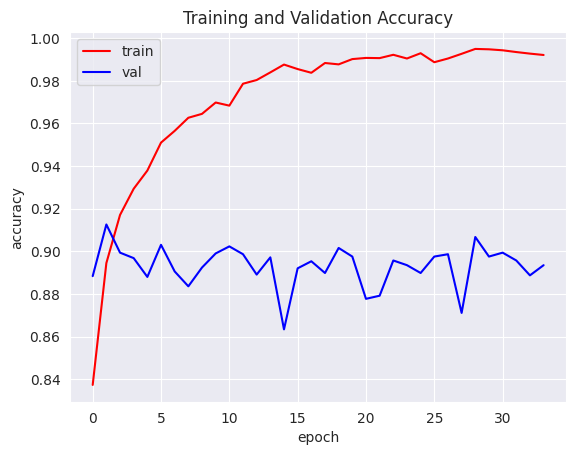

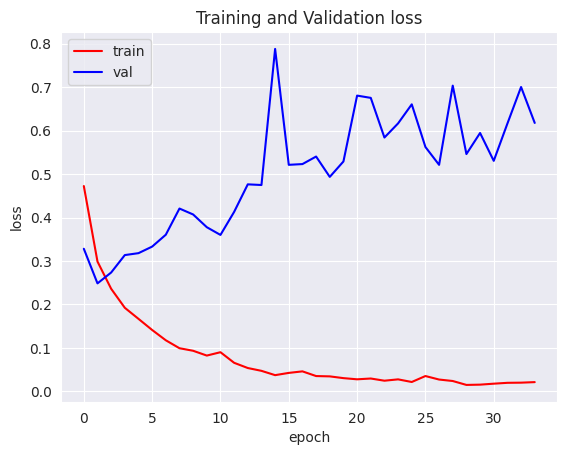

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation loss')
plt.show()

In [20]:
# 1. Reset generator
test_generator.reset()

# 2. Dapatkan prediksi mentah (probabilitas) dari model
preds_raw = model_1.predict(test_generator, verbose=0)

# 3. Konversi probabilitas menjadi label kelas (integer)
# np.argmax(axis=1) akan mengambil indeks dari nilai tertinggi di setiap baris
y_pred = np.argmax(preds_raw, axis=1)

# 4. Ambil label yang sebenarnya (integer)
y_true = test_generator.classes

# 5. Tentukan nama kelas
target_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# 6. Print Classification Report
print("\n")
print(classification_report(y_true=y_true,
                            y_pred=y_pred,
                            target_names=target_names,
                            digits=4))



              precision    recall  f1-score   support

   buildings     0.9026    0.9247    0.9135       531
      forest     0.9850    0.9794    0.9822       535
     glacier     0.8251    0.8224    0.8237       608
    mountain     0.8218    0.8312    0.8265       616
         sea     0.9225    0.9242    0.9234       554
      street     0.9287    0.9023    0.9153       563

    accuracy                         0.8943      3407
   macro avg     0.8976    0.8974    0.8974      3407
weighted avg     0.8946    0.8943    0.8944      3407



## Konversi Model

In [28]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.10.1 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.


In [29]:
# Convert model.h5 to tensorflow.js
!tensorflowjs_converter --input_format=keras best_model.h5 tfjs_model

2025-10-29 09:59:34.978654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761731975.027752   37723 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761731975.044591   37723 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761731975.100957   37723 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761731975.101016   37723 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761731975.101022   37723 computation_placer.cc:177] computation placer alr

In [22]:
#tflite

# Cek apakah variabel yang dibutuhkan ada
_ = model_1
_ = train_generator

# 1. Tentukan nama folder output
output_dir = 'tflite'

# 2. Buat folder 'tflite' jika belum ada
os.makedirs(output_dir, exist_ok=True)
print(f"Folder '{output_dir}' telah disiapkan.")

# 3. Konversi dan Simpan model.tflite
print("Memulai konversi model ke .tflite...")

# Inisialisasi TFLiteConverter
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)

# Lakukan konversi
tflite_model = converter.convert()

# Tentukan path lengkap untuk file model
tflite_model_path = os.path.join(output_dir, 'model.tflite')

# Simpan file .tflite
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

print(f"Model TFLite berhasil disimpan di: {tflite_model_path}")

# 4. Buat dan Simpan label.txt
print("\nMembuat file label.txt...")

# Dapatkan pemetaan kelas dari generator
class_indices = train_generator.class_indices

# Dapatkan nama-nama label sesuai urutan indeks (0, 1, 2, ...)
labels = list(class_indices.keys())

# Tentukan path lengkap untuk file label
tflite_labels_path = os.path.join(output_dir, 'label.txt')

# Simpan file label.txt
with open(tflite_labels_path, 'w') as f:
    for label in labels:
        f.write(label + '\n')

print(f"File label berhasil disimpan di: {tflite_labels_path}")


Folder 'tflite' telah disiapkan.
Memulai konversi model ke .tflite...
Saved artifact at '/tmp/tmpi8_yi200'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134983316460112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316462224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316464912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316464528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316463376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316465104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316463568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316465680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316465296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1349833164

In [23]:
base_serving_path = 'tf_serving_models'

# 2. Tentukan nama model Anda (ini akan menjadi nama API endpoint)
model_name = 'intel_classifier'

# 3. Tentukan versi model Anda (selalu gunakan integer)
model_version = 1

# 4. Buat path lengkap untuk menyimpan model
export_path = os.path.join(base_serving_path, model_name, str(model_version))

# 5. Buat direktori jika belum ada
os.makedirs(export_path, exist_ok=True)

print(f"Menyimpan model ke: {export_path}")

# 6. Simpan model
model_1.export(export_path)

Menyimpan model ke: tf_serving_models/intel_classifier/1
Saved artifact at 'tf_serving_models/intel_classifier/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134983316460112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316462224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316464912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316464528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316463376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316465104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316463568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316465680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134983316465296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134

## Inference (Optional)

In [26]:
export_path = 'tf_serving_models/intel_classifier/1'
LOCAL_IMAGE_PATH = 'test_street.jpeg'
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
print(f"Memuat model dari: {export_path}")
try:
    loaded_model_layer = tf.keras.layers.TFSMLayer(export_path, call_endpoint='serving_default')
    print("Model berhasil dimuat sebagai TFSMLayer.")
except Exception as e:
    print(f"GAGAL MEMUAT MODEL: {e}")
    raise e

try:
    print(f"\nMemuat gambar lokal dari: {LOCAL_IMAGE_PATH}")

    if not os.path.exists(LOCAL_IMAGE_PATH):
        raise FileNotFoundError(f"File tidak ditemukan di {LOCAL_IMAGE_PATH}. "
                                 "Pastikan Anda sudah meng-upload file dan namanya benar.")

    img = image.load_img(LOCAL_IMAGE_PATH, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array /= 255.0
    img_batch = np.expand_dims(img_array, axis=0)
    print(f"\nMelakukan inferensi pada gambar...")

    # Kita memanggil layer secara langsung
    predictions_dict = loaded_model_layer(img_batch)

    # Ekstrak array probabilitas dari dictionary output
    output_key = list(predictions_dict.keys())[0]
    if len(predictions_dict.keys()) > 1:
        print(f"Model memiliki beberapa output: {list(predictions_dict.keys())}. Menggunakan: '{output_key}'")

    probabilitas = predictions_dict[output_key][0] # Ambil array probabilitas
    predicted_class_index = np.argmax(probabilitas)
    predicted_class_name = class_names[predicted_class_index]
    confidence = np.max(probabilitas)

    print("\n===== HASIL INFERENSI =====")
    print(f"File Gambar: {LOCAL_IMAGE_PATH}")
    print(f"Gambar Diprediksi sebagai: {predicted_class_name.upper()}")
    print(f"Keyakinan (Confidence): {confidence * 100:.2f}%")
    print("---------------------------------")
    print("Probabilitas per kelas:")
    for i in range(len(class_names)):
        print(f"  {class_names[i]}: {probabilitas[i] * 100:.2f}%")

except Exception as e:
    print(f"\nGAGAL: Tidak dapat memproses gambar lokal.")
    print(f"Error: {e}")


Memuat model dari: tf_serving_models/intel_classifier/1
Model berhasil dimuat sebagai TFSMLayer.

Memuat gambar lokal dari: test_street.jpeg

Melakukan inferensi pada gambar...

===== HASIL INFERENSI =====
File Gambar: test_street.jpeg
Gambar Diprediksi sebagai: STREET
Keyakinan (Confidence): 99.98%
---------------------------------
Probabilitas per kelas:
  buildings: 0.02%
  forest: 0.00%
  glacier: 0.00%
  mountain: 0.00%
  sea: 0.00%
  street: 99.98%


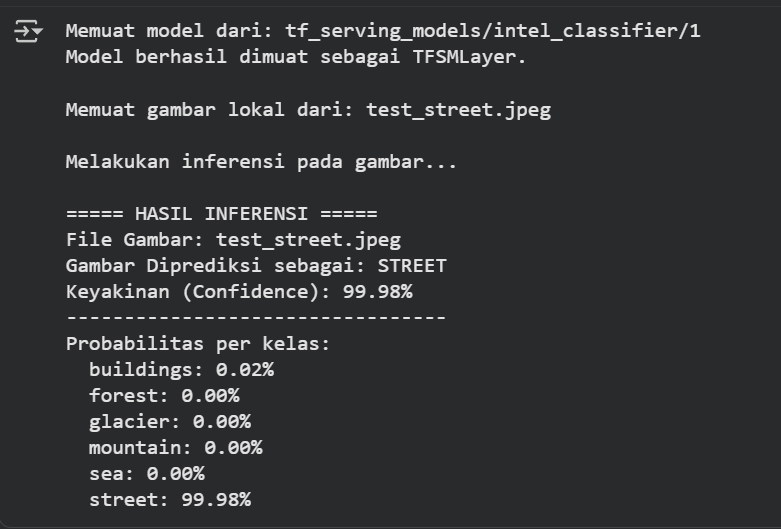

In [25]:
pip freeze requirements.txt

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.11.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.1
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.0
altair==5.5.0
annotated-doc==0.0.3
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.1
arrow==1.4.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.10.20.0.39.8
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.0.1
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.3
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.26.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.10.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.10.5
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3